In [1]:
import pandas as pd
import re
import csv
import ast
import matplotlib.pyplot as plt
from wordcloud import WordCloud

tweets = pd.read_csv('../tweets/tweets.csv', header=0)
print(tweets.isna().sum())
print()
tweets.drop(['user_id', 'created_at', 'retweet_count', 'retweeted',
             'favorite_count', 'source', 'expanded_urls',
             'posted', 'retweeted_status_id', 'in_reply_to_status_id'],
            axis=1, inplace=True)
# Remove rows with NaN text field
tweets = tweets[pd.notnull(tweets['text'])]

# Remove German tweets
for i, row in tweets.iterrows():
    if 'MerkelMussBleiben' in ast.literal_eval(row['hashtags']):
        tweets.drop(i, inplace=True)

tweets.reset_index(drop=True, inplace=True)
tweets.rename(columns={'created_str': 'date'}, inplace=True)
tweets.info()

user_id                    8065
user_key                      0
created_at                   21
created_str                  21
retweet_count            145399
retweeted                145399
favorite_count           145399
text                         21
tweet_id                   2314
source                   145398
hashtags                      0
expanded_urls                 0
posted                        0
mentions                      0
retweeted_status_id      163802
in_reply_to_status_id    202892
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203430 entries, 0 to 203429
Data columns (total 6 columns):
user_key    203430 non-null object
date        203430 non-null object
text        203430 non-null object
tweet_id    201116 non-null float64
hashtags    203430 non-null object
mentions    203430 non-null object
dtypes: float64(1), object(5)
memory usage: 5.4+ MB


In [2]:
def clean_text(text):
    from bs4 import BeautifulSoup

    # Remove URLs
    www_exp = r'www.[^ ]+'
    http_exp = r'http?s?[^\s]+'
    clean = re.sub('|'.join((www_exp, http_exp)), '', text)

    # Remove HTML encoded text (ampersand)
    soup = BeautifulSoup(clean, 'lxml')
    clean = soup.get_text()
    try:
        clean = clean.encode().decode().replace(u'\ufffd', '?')
    except UnicodeEncodeError or UnicodeDecodeError:
        clean = clean

    # Split 'not' contractions
    contraction_dict = {'can\'t': 'can not', 'won\'t': 'will not',
                        'isn\'t': 'is not', 'aren\'t': 'are not',
                        'wasn\'t': 'was not', 'weren\'t': 'were not',
                        'haven\'t': 'have not', 'hasn\'t': 'has not',
                        'wouldn\'t': 'would not', 'don\'t': 'do not',
                        'doesn\'t': 'does not', 'didn\'t': 'did not',
                        'couldn\'t': 'could not', 'shouldn\'t': 'should not',
                        'mightn\'t': 'might not', 'mustn\'t': 'must not',
                        'had\'t': 'had not'}
    contraction_exp = re.compile(r'\b(' + '|'.join(contraction_dict.keys()) + r')\b')
    clean = contraction_exp.sub(lambda x: contraction_dict[x.group()], clean)

    # Remove @ mentions and hashtags
    at_exp = r'@[A-Za-z0-9_]+'
    hashtag_exp = r'#[A-Za-z0-9_]+'
    clean = re.sub('|'.join((at_exp, hashtag_exp)), '', clean)
    
    # Remove non-letter chars, 'RT'/'MT' from retweets, enclitics from split contractions
    clean = re.sub('[^a-zA-Z]', ' ', clean)
    tails = [r'\bRT\b', r'\bMT\b', r'\bve\b', r'\bre\b', r'\bll\b']
    clean = re.sub('|'.join(tails), '', clean)
    # Convert to lower case
    clean = clean.lower()

    return " ".join([word for word in clean.split(" ") if word is not ''])


tweets['clean_text'] = tweets['text'].apply(clean_text)

C:\Users\jmelt\AppData\Roaming\Python\Python36\site-packages\bs4\__init__.py:273: UserWarning: "b'... '" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\jmelt\AppData\Roaming\Python\Python36\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


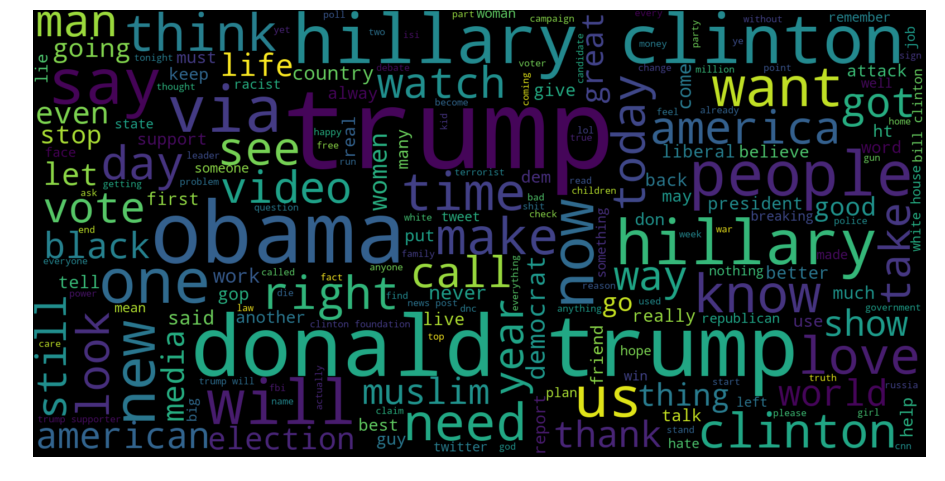

In [3]:
# Generate word cloud
tweet_text = tweets.clean_text.str.cat(sep=' ')
wordcloud = WordCloud(width=1600,
                      height=800,
                      max_font_size=200).generate(tweet_text)
fig = plt.figure(figsize=(16, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# fig.savefig('../visuals/wordcloud.png')

In [4]:
tweets.to_csv('../tweets/tweets_clean.csv', index=False, quoting=csv.QUOTE_ALL)